# Truss Dynamics


## Scope

This notebook uses the **(Point Mass Dynamics) PMD** class to the dynamic behavior of a truss structure.

## Coding


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate, optimize, spatial
from matplotlib import animation, rc
import sympy as sp
from PMD import PMD, distances, MetaForce
sp.init_printing(use_latex = "mathjax")
rc('animation', html='html5')
%matplotlib nbagg


In [25]:
class Truss(PMD):
    def __init__(self, K, D, C, L0, F, dof, **kwargs):
        """
        2D Truss Dynamics
        """
        self.K = K
        self.D = D
        self.C = C
        self.L0 = L0
        self.F = F
        self.dof = dof
        super().__init__(**kwargs)
 
    def derivative(self, X, t):
        """
        Point Mass acceleration
        """      
        m = self.m
        K, C = self.K, self.C
        L0, dof = self.L0, self.dof
        n = len(m)
        P = X[:2 * n ].reshape(n ,2)
        V = X[ 2 * n:].reshape(n ,2)
        M = m * m[:, np.newaxis]
        D, R, U = distances(P)
        F = F.copy()
        for i in xrange(len(conn)):
            nodes  = P[C[i]]
            dist   = nodes[1] - nodes[0]
            length = (dist**2).sum()**.5
            f = -K[i]* (length - L0[i]) * dist / length
            F[c[1]] +=  f
            F[c[0]] -=  f
        A = (F.T /m).T
        X2 = X.copy()
        X2[:2*n ] = V.flatten()
        X2[ 2*n:] = A.flatten()
        return X2       

  
 

## Simulating a case with high symmetry

In [36]:
# Nodes
nx, ny = 2, 10
x = np.linspace(0., 1., nx)
y = np.linspace(0., 4., ny)
X, Y = np.meshgrid(x,y)
X, Y = X.flatten(), Y.flatten()
P = np.array([X, Y]).T
Tri = spatial.Delaunay(P)
Simp = Tri.simplices
beams= []
for s in Simp:
    beams.append((s[0],s[1]))
    beams.append((s[1],s[2]))
    beams.append((s[2],s[0]))
for i in range(len(beams)):
    beams[i] = tuple(sorted(beams[i]))
conn = np.array(sorted(set(beams)))  
m  = np.ones(nx * ny)*1.
L0 = [((X[c[1]] - X[c[0]])**2 
     + (Y[c[1]] - Y[c[0]])**2)**.5 for c in conn ]
K  = np.ones(len(beams))*1.e4
F = np.zeros_like(P)
F[:, 0] = m * 2000.
bdof = np.ones_like(P) 
bdof[0:nx,:] = 0.
V = np.zeros_like(P)
D = np.zeros_like(m)
truss = Truss(m = m, P = P, V = V, K=K, D=D, C = conn, L0 = L0, F=F, dof = bdof)

<IPython.core.display.Javascript object>


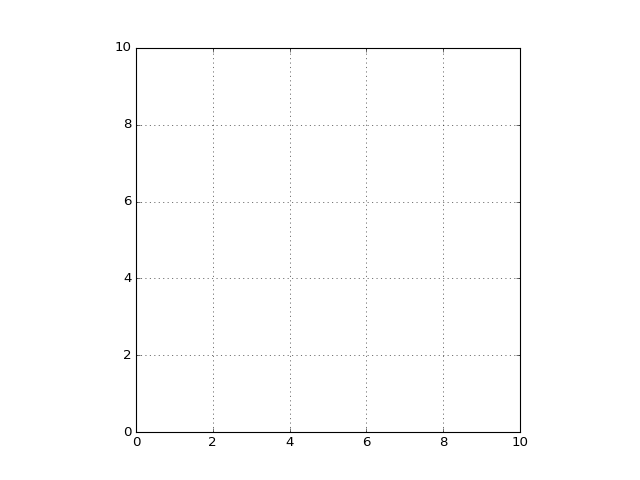

In [39]:
pcolors = "r"
tcolors = "k"
nm = nx*ny

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect("equal")
margin = 1.
plt.axis([0, 10, 0, 10])
plt.grid()
#ax.axis("off")
points = []

msize = 10. * (truss.m / truss.m.max())**(1./6.)
for i in range(nm):
    plc = len(pcolors)
    pc = pcolors[i%plc]
    tlc = len(tcolors)
    tc = tcolors[i%tlc]
    trail, = ax.plot([], [], "-"+tc)
    point, = ax.plot([], [], "o"+pc, markersize = msize[i])
    points.append(point)
    points.append(trail)

    
def init():
    for i in range(2 * nm):
        points[i].set_data([], [])
    return points 

def animate(i):
    truss.solve(dt, nt)
    x, y = truss.xy()
    for i in range(nm):
        points[2*i].set_data(x[i:i+1], y[i:i+1])
        xt, yt = truss.trail(i)
        points[2*i+1].set_data(xt, yt)
    return points

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=800, interval=20, blit=True)

"""
plt.close()
anim"""

plt.show()

<IPython.core.display.Javascript object>


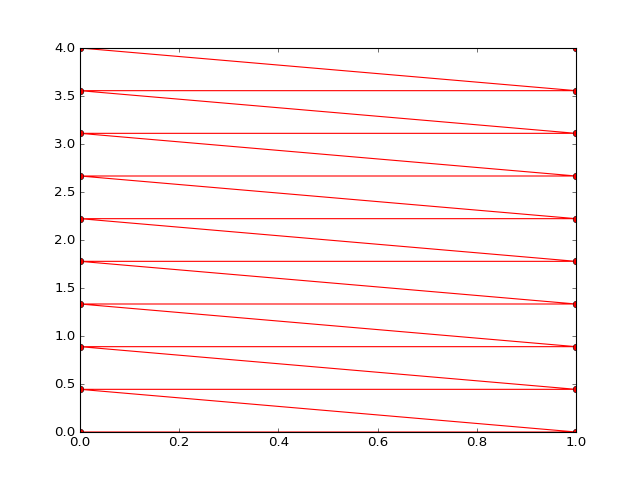

In [38]:
plt.figure()
x, y = truss.positions.T
plt.plot(x, y, "or-")
plt.show()